In [1]:
%matplotlib inline

In [2]:
import cv2
import os
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam,SGD
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig('' + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

In [4]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256

In [5]:
#Load all patients 
my_data = pd.read_csv('../data/Five_Frames_Per_patient.csv')
patients_data=pd.read_csv('../data/videos_data.csv')
data_array = my_data.to_numpy()
patients_array=patients_data["FileName"].to_numpy()
images_path = '../data/Five_Frames_Per_patient/'
no_of_test_patients=math.floor(patients_array.size*0.2) 
images_data = []
models = []

df=my_data
data_array=df.to_numpy()
for i in data_array:
    img = cv2.imread(images_path + i[0] + '.' + i[2])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img_2d = img.reshape(IMAGE_WIDTH ,IMAGE_HEIGHT,3)
    images_data.append(img_2d)

X=np.asarray(images_data)
X=X/255.0
y = np.asarray(my_data['Label'])
print(Counter(y))

Counter({'regular': 280, 'pneumonia': 180, 'covid': 150})


In [6]:
testPatient_indexes= [1,2,15,16,21,22,
                      33,34,42,43,52,53,63,
                      92,95,96,99,101,102,105,110]

In [7]:
#getting frame indexes of each patient
frames_index=[]
for i in testPatient_indexes:
  j=i*5
  z=j+5
  while j<z:
    frames_index.append(j)
    j+=1

# Adding the frames to X_test
X_test=np.take(X,frames_index,axis=0)
y_test=np.take(y,frames_index,axis=0)
# Removing the frames from X_train
X_train=np.delete(X,frames_index,axis=0)
y_train=np.delete(y,frames_index,axis=0)

# Scale the pixels
X_train=X_train/255.0
X_test=X_test/255.0

In [8]:
#Applying SMOTE
oversample = SMOTE()
X_train=np.resize(X_train,(X_train.shape[0],196608))
X_train,y_train=oversample.fit_resample(X_train, y_train)
X_train=np.resize(X_train,(X_train.shape[0],256,256,3))
counter=Counter(y_train)
print(counter)

#Label encode classes to numbers
#One-hot Encode y
number = preprocessing.LabelEncoder()
y_train=number.fit_transform(y_train)
y_train=to_categorical(y_train,3)

number2 = preprocessing.LabelEncoder()
y_test=number2.fit_transform(y_test)
y_test=to_categorical(y_test,3)

Counter({'covid': 240, 'pneumonia': 240, 'regular': 240})


In [9]:
print('X_train: '+str(X_train.shape))
print('y_train: '+str(y_train.shape))
print('X_test: '+ str(X_test.shape))
print('y_test: '+ str(y_test.shape))

X_train: (720, 256, 256, 3)
y_train: (720, 3)
X_test: (105, 256, 256, 3)
y_test: (105, 3)


In [10]:
# initialize the training data augmentation object
MODEL_PATH=os.path.join('', "Conv2d-SMOT")

trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

mcp_save = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [11]:
BATCH_SIZE=16
EPOCHS=20
LR=1e-4
opt = Adam(learning_rate=LR,decay=LR / 20)
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=7,
    verbose=1,
    min_delta=1e-4,
    mode='min'
)

In [12]:
drop=0.1
kernel=(2,2)
# Create model
model = Sequential()

model.add(Conv2D(16, kernel_size=kernel, activation='relu', 
                 kernel_initializer='he_uniform', padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

model.add(Conv2D(16, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(32, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(64, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(126, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(126, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(256, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(256, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))


#Flatten results
model.add(Flatten())

#Hidden layers of 512 neurons
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))


In [13]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history=model.fit(
    trainAug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/20
45/45 [==============================] - 17s 296ms/step - loss: 1.0892 - accuracy: 0.3431 - val_loss: 1.0759 - val_accuracy: 0.2095

Epoch 00001: val_accuracy improved from -inf to 0.20952, saving model to Conv2d-SMOT
INFO:tensorflow:Assets written to: Conv2d-SMOT\assets
Epoch 2/20
45/45 [==============================] - 12s 254ms/step - loss: 1.0083 - accuracy: 0.4556 - val_loss: 0.9529 - val_accuracy: 0.6000

Epoch 00002: val_accuracy improved from 0.20952 to 0.60000, saving model to Conv2d-SMOT
INFO:tensorflow:Assets written to: Conv2d-SMOT\assets
Epoch 3/20
45/45 [==============================] - 12s 258ms/step - loss: 0.8916 - accuracy: 0.5778 - val_loss: 0.9802 - val_accuracy: 0.5524

Epoch 00003: val_accuracy did not improve from 0.60000
Epoch 4/20
45/45 [==============================] - 12s 256ms/step - loss: 0.8486 - accuracy: 0.6444 - val_loss: 0.8017 - val_accuracy: 0.5714

Epoch 00004: val_accuracy did not improve from 0.60000
Epoch 5/20
45/45 [===============

Train: 0.885, Test: 0.800


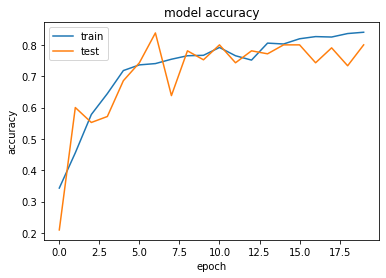

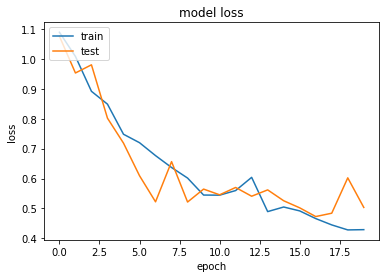

In [15]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'],
           loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import classification_report
y_pred=(model.predict(X_test) > 0.5).astype("int32")
y_pred=[np.argmax(x) for x in y_pred]
y_testLabeled=[np.argmax(x) for x in y_test]
target_names = ['Covid', 'Pneumonia', 'Healthy']
print(classification_report(y_testLabeled, y_pred,target_names=target_names))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_testLabeled,y_pred))

              precision    recall  f1-score   support

       Covid       0.78      0.60      0.68        30
   Pneumonia       1.00      0.74      0.85        35
     Healthy       0.62      0.88      0.73        40

    accuracy                           0.75       105
   macro avg       0.80      0.74      0.75       105
weighted avg       0.80      0.75      0.76       105

[[18  0 12]
 [ 0 26  9]
 [ 5  0 35]]
